In [60]:
import csv
import numpy as np
import copy
import math
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt

In [61]:
def split_train_label(data):
    train_x = []
    train_y = []
    for i in data:
        train_x.append(i[1:])
        train_y.append([i[0]])
        
    return train_x,train_y

In [62]:
with open('titanic_data.csv','r') as file:
    temp = csv.reader(file)
    data = list(temp)

header = data[0]
data = data[1:]
for i in range(len(data)):
    row_len = len(data[0])
    for j in range(row_len):
        data[i][j] = float(data[i][j])
    
train_x, train_y = split_train_label(data)

# Convert all features into binary features

I used average as the criteria to change the data

In [63]:
#binary conversion
binary_avg = []
for i in range(len(header[1:])):
    total = 0
    avg = 0
    for j in train_x:
        total += j[i]  
    avg = total/len(train_x)      
    binary_avg.append(avg)
    
for i in range(len(train_x)):
    for j in range(len(train_x[0])):
        if train_x[i][j] >= binary_avg[j]:
            train_x[i][j] = 1.0
        else:
            train_x[i][j] = 0.0
            
print(binary_avg)

[2.305524239007892, 0.35400225479143177, 29.471443066516347, 0.5253664036076663, 0.3833145434047351, 32.30542018038328]


In [64]:
def k_cross_validation(x,y,model,k=10):
    interval = math.ceil(len(train_x)/k)
    global_accuracy = []
    for i in range(10):
        local_accuracy = 0
        count = 0
        tr_x = []
        tr_y = []
        te_x = []
        te_y = []
        te_x += x[i*interval : (i+1)*interval]
        te_y += y[i*interval : (i+1)*interval]
        tr_x += x[0:i*interval]
        tr_x += x[(i+1)*interval:]
        tr_y += y[0:i*interval]
        tr_y += y[(i+1)*interval:]
        
        predictor = model(tr_x, tr_y)
        for j in range(len(te_x)):
            if predictor.predict(te_x[j]) == te_y[j][0]:
                count += 1
        global_accuracy.append(count/len(te_x))
    return sum(global_accuracy)/len(global_accuracy), global_accuracy
        

# KNN Model

In [65]:
class KNN:
    def __init__(self,train_x,train_y,k_parameter = 3): # input can be k
        self.train_x = np.array(train_x)
        self.train_y = np.array(train_y)
        self.k_parameter = k_parameter
    def predict(self,test_x):
        test_x = np.array(copy.deepcopy(test_x))
        all_distance = []
        for idx in range(len(self.train_x)):
            single_train_x = self.train_x[idx]
            difference = np.subtract(single_train_x,test_x)
            distance = 0
            for single_error in difference:
                distance += abs(single_error)
            all_distance.append((idx,distance))
        all_distance = sorted(all_distance, key = self.get_difference)
        prediction = sum(self.train_y[x[0]] for x in all_distance[:self.k_parameter])/self.k_parameter
        
        if prediction > 0.5:
            return 1
        else:
            return 0
        #return prediction
    def get_difference(self,distance_element):
        return distance_element[1]

In [66]:
predictor = KNN(train_x,train_y)

In [67]:
predictor.predict([1,0,0,0,0,1])

0

In [68]:

total_k = []
for i in range(1,101):
    total_k.append(i)

In [ ]:
result = []
for i in total_k:
    predictor = KNN(train_x,train_y,k_parameter = i)
    result.append(predictor.predict([1,0,0,0,0,1])[0])
print(result)

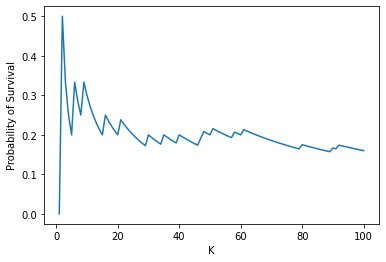

In [10]:
import matplotlib.pyplot as plt
plt.plot(total_k,result)
plt.ylabel('Probability of Survival')
plt.xlabel('K')
plt.show()


In [70]:
result = k_cross_validation(train_x,train_y,KNN)
validation_accuracy_list = result[1]
validation_accuracy = result[0]
print(validation_accuracy,validation_accuracy_list)

0.7881369218709171 [0.7078651685393258, 0.8426966292134831, 0.7640449438202247, 0.797752808988764, 0.797752808988764, 0.797752808988764, 0.7640449438202247, 0.7528089887640449, 0.8426966292134831, 0.813953488372093]


# Naive Bayes Model

In [71]:
with open('titanic_data.csv','r') as file:
    temp = csv.reader(file)
    data = list(temp)

header = data[0]
data = data[1:]
for i in range(len(data)):
    row_len = len(data[0])
    for j in range(row_len):
        data[i][j] = float(data[i][j])
    
train_x, train_y = split_train_label(data)

In [72]:
class NaiveBayes:
    def __init__(self,train_x,train_y):
        self.train_x = np.array(train_x)
        self.train_y = np.array(train_y)
    def normal_pdf(self,average,variance,test_value):
        likelihood = 1/(np.sqrt(2 * np.pi * variance)) * np.exp( - (test_value - average)**2 / (2 * variance))
        return(likelihood)
    def predict(self,test_x):
        test_x = np.array(copy.deepcopy(test_x))
        # divide data into two class
        total_class = [[],[]]
    
        for i in range(len(self.train_x)):
            if self.train_y[i] == 0:
                total_class[0].append(self.train_x[i])
            elif self.train_y[i] == 1:
                total_class[1].append(self.train_x[i])              
        #calculate class 0 posterior
        class_probability = [0,0]
        for class_idx in range(2): # go over all class
            p_y = len(total_class[class_idx])/(len(total_class[0])+len(total_class[1]))
            for feature in range(len(self.train_x[0])):
                if feature == 0: # pclass multinomial
                    count = 0
                    for i in total_class[class_idx]:
                        if i[feature] == test_x[feature]:
                            count += 1
                    p_y = p_y * (count+1)/(len(total_class[class_idx])+3)
                elif feature == 1: # gender binomial
                    count = 0
                    for i in total_class[class_idx]:
                        if i[feature] == test_x[feature]:
                            count += 1
                    p_y = p_y * (count+1)/(len(total_class[class_idx])+2)
                else: # continuous
                    continuous_list = []
                    for i in total_class[class_idx]:
                        continuous_list.append(i[feature])
                    avg = sum(continuous_list)/len(continuous_list)
                    var = np.var(continuous_list)
                    p_y = p_y * self.normal_pdf(avg,var,test_x[feature])
            class_probability[class_idx] = p_y
        if class_probability[0] >= class_probability[1]:
            return 0
        else:
            return 1
        #return class_probability

In [73]:
NB_predictor = NaiveBayes(train_x, train_y)

In [74]:
NB_predictor.predict([2.0, 0.0, 25.0, 0.0, 0.0, 53.1])

0

In [75]:
#cross validation

k_cross_validation(train_x,train_y,NaiveBayes)

(0.7780637575124117,
 [0.6853932584269663,
  0.8202247191011236,
  0.7528089887640449,
  0.7528089887640449,
  0.7640449438202247,
  0.8089887640449438,
  0.7865168539325843,
  0.7752808988764045,
  0.8089887640449438,
  0.8255813953488372])